### 本 notebook 使用经典的 Auto MPG 数据集，构建了一个用来预测70年代末到80年代初汽车燃油效率的模型。为了做到这一点，我们将为该模型提供许多那个时期的汽车描述。这个描述包含：气缸数，排量，马力以及重量。

In [95]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.0.0


# 1 导入数据

In [96]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv('data/auto/auto-mpg.data', names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [65]:
dataset.isna().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [97]:
dataset.dropna(inplace=True)

## "Origin" 列实际上代表分类，而不仅仅是一个数字。所以把它转换为独热码 （one-hot）:

In [98]:
origin = dataset.pop('Origin')

In [99]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 拆分训练数据集和测试数据集
### 现在需要将数据集拆分为一个训练数据集和一个测试数据集。

### 我们最后将使用测试数据集对模型进行评估。

In [100]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## 数据检查
#### 快速查看训练集中几对列的联合分布。

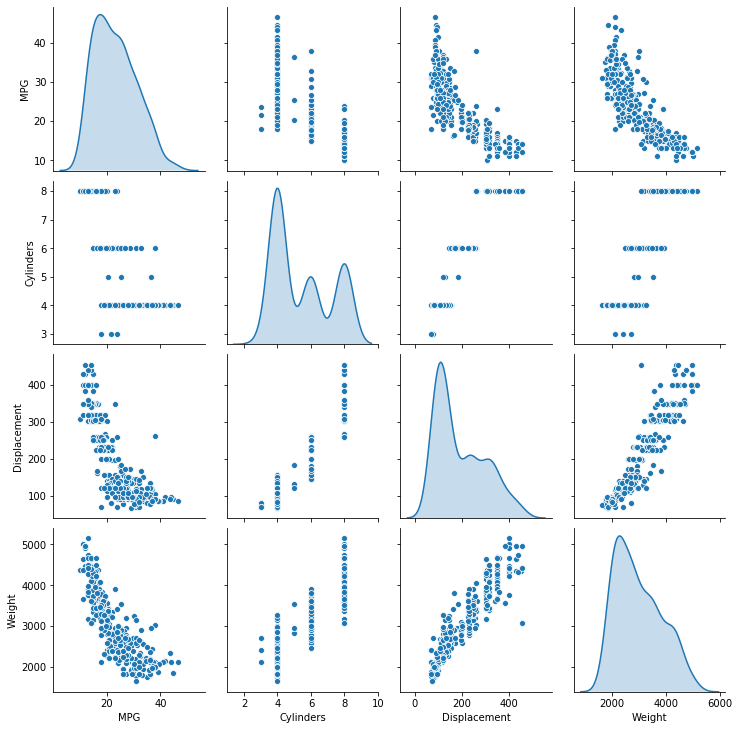

In [70]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

## 也可以查看总体的数据统计:



In [101]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [102]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

# 数据规范化
### 再次审视下上面的 train_stats 部分，并注意每个特征的范围有什么不同。

### 使用不同的尺度和范围对特征归一化是好的实践。尽管模型可能 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

注意：尽管我们仅仅从训练集中有意生成这些统计数据，但是这些统计信息也会用于归一化的测试数据集。我们需要这样做，将测试数据集放入到与已经训练过的模型相同的分布中。

In [103]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1.0,0.0,0.0
229,8,400.0,180.0,4220.0,11.1,77,1.0,0.0,0.0
150,4,108.0,93.0,2391.0,15.5,74,0.0,0.0,1.0
145,4,83.0,61.0,2003.0,19.0,74,0.0,0.0,1.0


# 模型
## 构建模型
### 我们将会使用一个“顺序”模型，其中包含两个紧密相连的隐藏层，以及返回单个、连续值得输出层。模型的构建步骤包含于一个名叫 'build_model' 的函数中，稍后我们将会创建第二个模型。 两个密集连接的隐藏层。

In [75]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [76]:
model = build_model()


In [78]:
model.summary()#查看模型

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


现在试用下这个模型。从训练数据中批量获取‘10’条例子并对这些例子调用 model.predict 。

In [79]:
example_batch = x_train[:10]
example_result = model.predict(example_batch)
example_result


array([[-0.16439907],
       [-0.33069348],
       [-0.06562192],
       [-0.04412445],
       [-0.02547209],
       [ 0.00378875],
       [-0.01443318],
       [-0.28698507],
       [-0.12707204],
       [-0.22342694]], dtype=float32)

# 训练模型
## 对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。

In [81]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: 
        print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## 使用 history 对象中存储的统计信息可视化模型的训练进度。

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.604407,1.023290,2.604407,8.624634,2.244910,8.624634,995
996,2.449139,1.008732,2.449140,8.909214,2.319182,8.909214,996
997,2.480658,1.007772,2.480659,9.434973,2.290742,9.434974,997
998,2.590075,1.057782,2.590075,8.053925,2.090966,8.053925,998
999,2.418015,1.036962,2.418015,8.749156,2.293584,8.749155,999


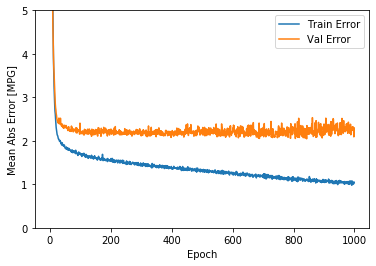

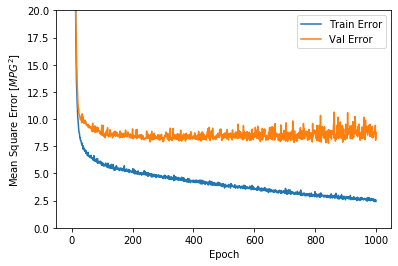

In [84]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

### 该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。 我们将使用一个 EarlyStopping callback 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。

你可以从这里学习到更多的回调。


...............................................

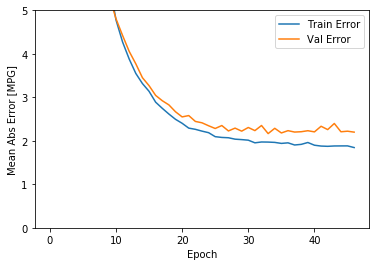

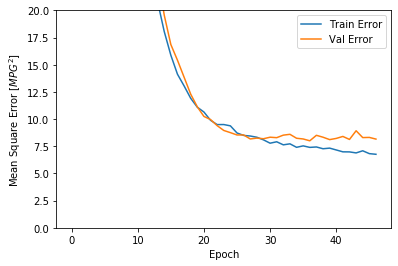

In [86]:
model = build_model()

# patience 值用来检查改进 epochs 的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

如图所示，验证集中的平均的误差通常在 +/- 2 MPG左右。

让我们看看通过使用 测试集 来泛化模型的效果如何，我们在训练模型时没有使用测试集。这告诉我们，当我们在现实世界中使用这个模型时，我们可以期望它预测得有多好。

In [87]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.9810 - mae: 1.9160 - mse: 5.9810
Testing set Mean Abs Error:  1.92 MPG


# 做预测
### 最后，使用测试集中的数据预测 MPG 值:

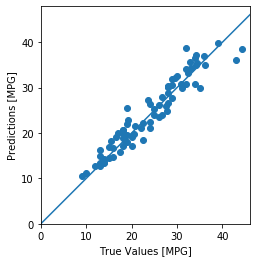

In [88]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


### 这看起来我们的模型预测得相当好。我们来看下误差分布。



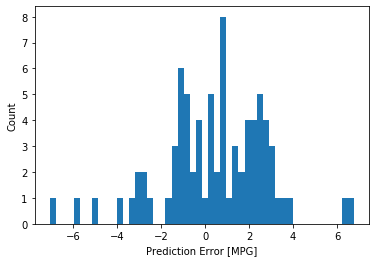

In [91]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# 它不是完全的高斯分布（正态分布），但我们可以推断出，这是因为样本的数量很小所导致的。

